In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import torch
import gc
import os
import sys
%matplotlib notebook
import matplotlib.pyplot as plt

def printmem():
    allocated = torch.cuda.memory_allocated()
    cached = torch.cuda.memory_cached()
    print('All|ocated:', str(allocated), '['+str(round(allocated/1000000000,3))+' GB]')
    print('   Cached:', str(cached), '['+str(round(cached/1000000000,3))+' GB]')

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
printmem()



All|ocated: 0 [0.0 GB]
   Cached: 0 [0.0 GB]


In [2]:
# owlnet = OwlNet.load_model('/home/hazmat/Documents/mayonoise/hypersearch/results/IPjCNbjTOjY7goYijeW6IPy6FQvJJsTf/', 'trial_0model')
# print(owlnet)

In [3]:
from criteria import PidgeonNetLoss
from helpers import Trainer
from helpers import Logger
from helpers import Trial
from mibi_dataloader import MIBIData
from modules import PidgeonNet
import utils

printmem()

All|ocated: 0 [0.0 GB]
   Cached: 0 [0.0 GB]


In [4]:
# Load the data
main_dir = '/home/hazmat/Documents/embedder/'
train_dir = main_dir + 'data/train/'
modl_dir = main_dir + 'models/'
rslt_dir = main_dir + 'results/'

train_ds = MIBIData(complex_folder=train_dir, crop=32, scale=10, stride=16, flag='complex')
# test_ds = MIBIData(folder=test_dir, labels=labels, crop=32, scale=10, stride=16)

printmem()

Loading.......97.29729729729729%%
There are  29008 samples
All|ocated: 0 [0.0 GB]
   Cached: 0 [0.0 GB]


In [5]:
train_ds.prepare_epoch()

In [6]:
batch = train_ds.get_next_minibatch(1)

In [7]:
print(batch['c'].shape)
print(batch['x'].shape)
print(torch.unique(batch['c']))

torch.Size([1, 1, 32, 32])
torch.Size([1, 39, 32, 32])
tensor([0.], device='cuda:0')


In [8]:
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(10,10))
# plt.imshow(batch['c'][0,0,:,:].cpu())
# fig.show()

In [9]:
pidgeonnet_args = dict()
pidgeonnet_args['kind'] = 'conv'

pidgeonnet_args['kernel_size'] = 3
pidgeonnet_args['padding'] = 1
pidgeonnet_args['dilation'] = 1
pidgeonnet_args['stride'] = 1

# pidgeonnet_args['layer_dims'] = [39, 20, 10]
# owlnet_args['num_layers'] = 5
# owlnet_args['in_dim'] = 29
pidgeonnet_args['code_dim'] = 10
pidgeonnet_args['in_dim'] = 39
pidgeonnet_args['embed_dim'] = 64
pidgeonnet_args['embed_layers'] = 4

pidgeonnet_args['noise_std'] = .2

torch.cuda.empty_cache()
pidgeonnet = PidgeonNet(**pidgeonnet_args)

pidgeonnet.cuda()
# print(owlnet)

PidgeonNet(
  (conv_net): Sequential(
    (conv_0): CoordConv(
      (addcoords): AddCoords()
      (conv): Conv2d(41, 29, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (prelu_0): PReLU(num_parameters=1)
    (conv_1): CoordConv(
      (addcoords): AddCoords()
      (conv): Conv2d(31, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (prelu_1): PReLU(num_parameters=1)
    (conv_2): CoordConv(
      (addcoords): AddCoords()
      (conv): Conv2d(21, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (prelu_2): PReLU(num_parameters=1)
  )
  (init_conv): CoordConv(
    (addcoords): AddCoords()
    (conv): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (init_prelu): PReLU(num_parameters=1)
  (gru): ConvGRU(
    (sigmoid): Sigmoid()
    (tanh): Tanh()
    (prelu): PReLU(num_parameters=1)
    (W_h): CoordConv(
      (addcoords): AddCoords()
      (conv): Conv2d(66, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

In [10]:
print(next(pidgeonnet.parameters()).is_cuda)

True


In [11]:
# pidgeonnet.ladder.suggested_in_size(32)

In [12]:
pidgeonnet_trainer = Trainer()
pidgeonnet_logger = Logger({'loss':(list(),list())})

# LadderNet training parameters
pidgeonnet_train_args = dict()
pidgeonnet_train_args['lr'] = .0001
pidgeonnet_train_args['batch_size'] = 20
pidgeonnet_train_args['epochs'] = 5
pidgeonnet_train_args['report'] = 5
pidgeonnet_train_args['crop'] = 8
pidgeonnet_train_args['clip'] = 1
pidgeonnet_train_args['decay'] = 0
# LadderNet loss parameters
pidgeonnet_loss_args = {
    'lambdas': [2**0, 2**-1, 2**-2, 2**-3, 2**-4]
}

train_ds.set_crop(pidgeonnet_train_args['crop'])

In [13]:
# owlnet_trainer.test(trial.model, train_ds, trial.criterion, trial.test_logger)

In [14]:
# for layer in trial.model.ladder.variables:
#     print(layer)

In [15]:
# lambdas = [2**0, 2**-1, 2**-2, 2**-3, 2**-4]
# print(lambdas)

In [16]:
# pidgeonnet.set_noise_std(0.1)
# pidgeonnet.set_lateral_weight(1)
pidgeonnet.set_num_steps(10)
pidgeonnet_criterion = PidgeonNetLoss(**pidgeonnet_loss_args)
pidgeonnet_trainer.train(pidgeonnet, train_ds, pidgeonnet_criterion, pidgeonnet_logger, **pidgeonnet_train_args)
print()
torch.cuda.empty_cache()
printmem()


Epoch:0 > < {'loss': tensor(3.5422, device='cuda:0')}
Epoch:1 > < {'loss': tensor(3.5019, device='cuda:0')}
Epoch:2 > < {'loss': tensor(2.7931, device='cuda:0')}
Epoch:3 > < {'loss': tensor(3.7756, device='cuda:0')}
Epoch:4 > < {'loss': tensor(3.6877, device='cuda:0')}
trained in 945.6194696426392 seconds

All|ocated: 2795520 [0.003 GB]
   Cached: 8388608 [0.008 GB]


<IPython.core.display.Javascript object>


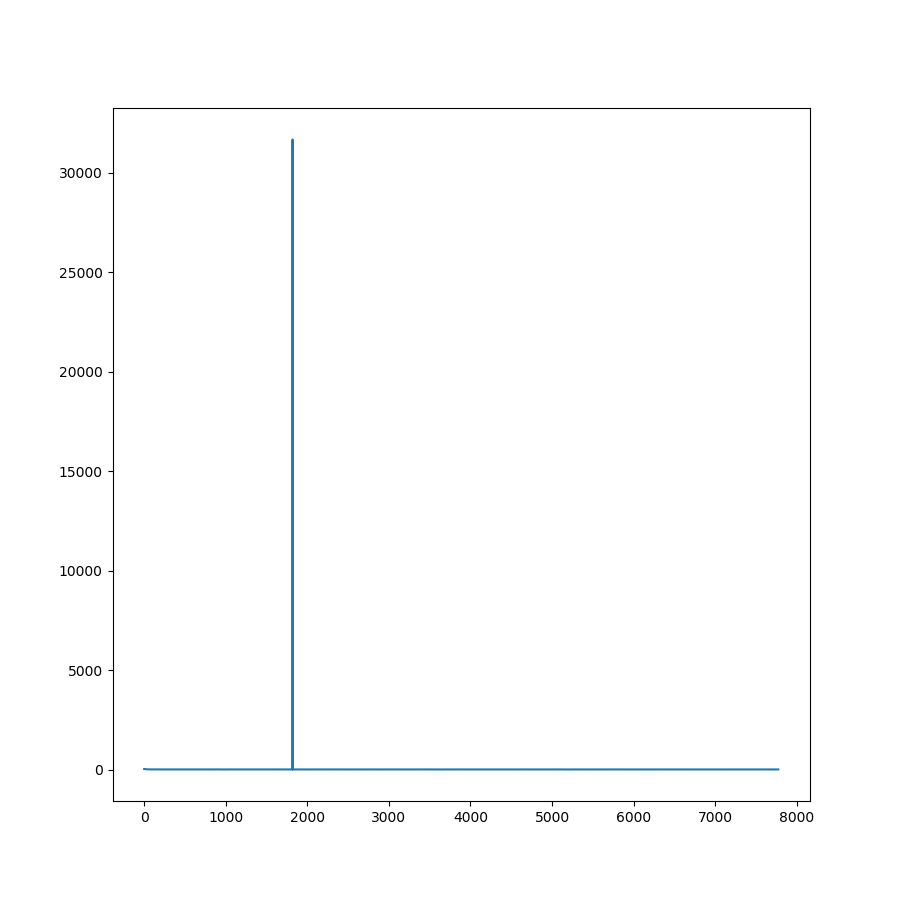

In [17]:
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(9,9))
plt.plot(pidgeonnet_logger.list_vars['loss'][1][0:])
fig1.show()

In [18]:
train_ds.set_crop(64)
batch = train_ds.get_batch(1, False)
output = pidgeonnet(**batch)

/home/hazmat/GitHub/Hawkeye/mibi_dataloader.py:343: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'x': torch.tensor(sample).float().cuda(),


<IPython.core.display.Javascript object>


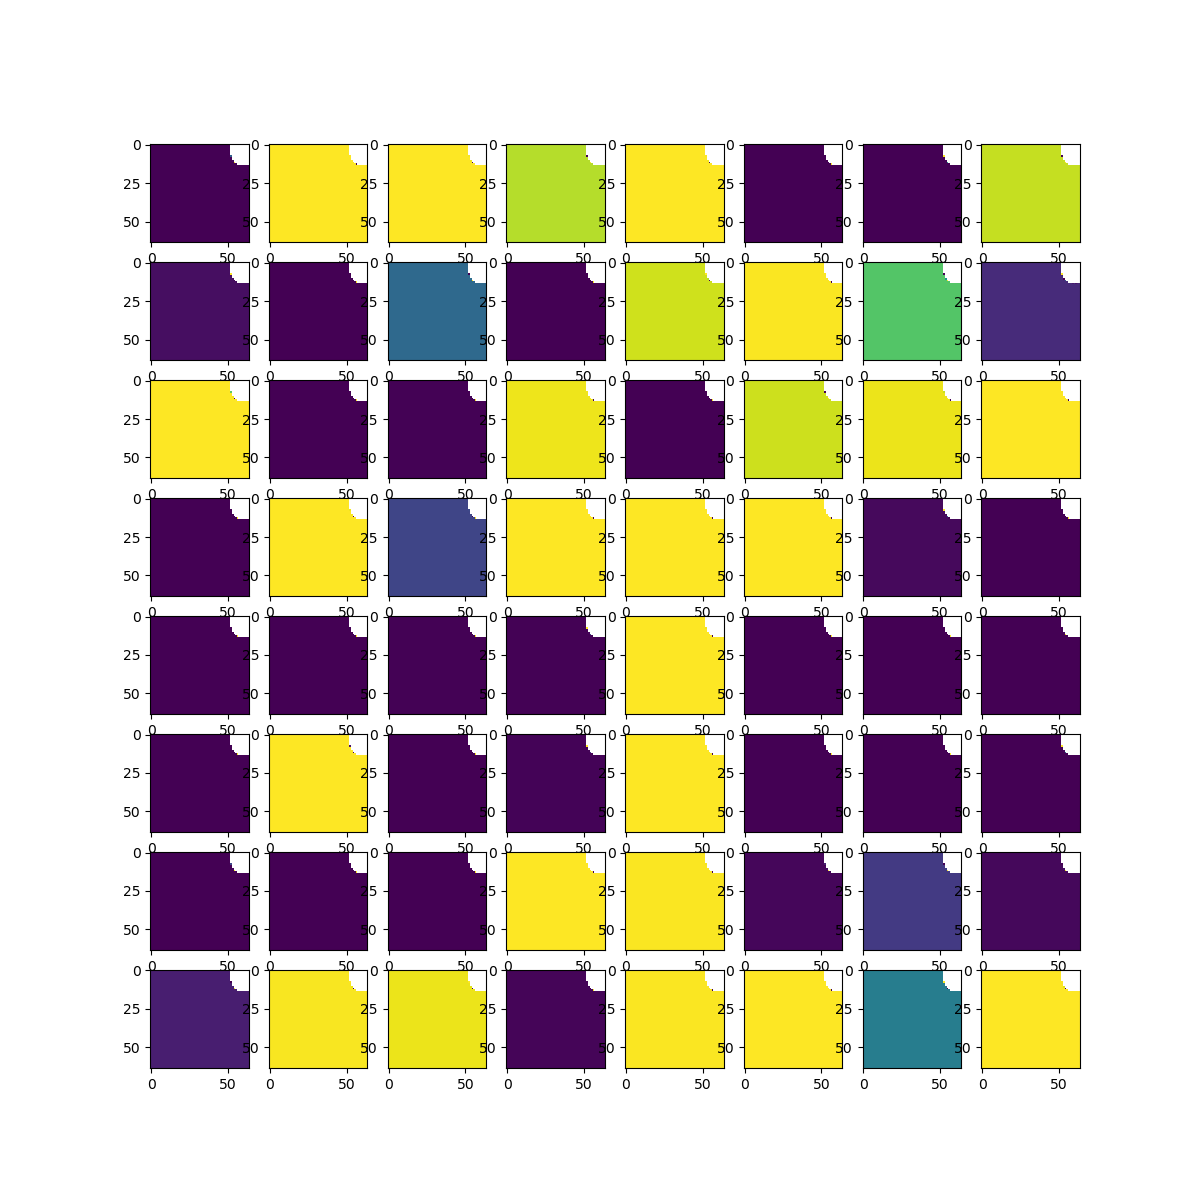

In [19]:
embedding = output['y'][0,:,:,:].transpose(0,1).transpose(1,2).cpu().detach()
fig2 = plt.figure(figsize=(12,12))
index = 0
for i in range(8):
    for j in range(8):
        plt.subplot(8,8,index+1)
        plt.imshow(embedding[:,:,index].numpy())
        index += 1
fig2.show()
